Author: Kevin M. Loew

Last Modifed:July 23, 2019

Description: This notebook uses a pretrained neural network and retrains it for a new purpose. The data used is from a Kaggle dataset (Intel Image Classification).

This one uses tensorflow and keras layers.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import platform
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score
from sklearn.preprocessing import normalize
from tensorflow.keras.applications import ResNet50
import time

print('python: ', platform.python_version())
print('tensorflow: ', tf.__version__)

python:  3.6.8
tensorflow:  1.13.1


Declare paths to data.

In [2]:
training_path='seg_train'
test_path='seg_test'

In [3]:
class_dict={}
for i in os.listdir(training_path):
    class_dict[i] =  os.listdir(training_path+'/'+i)

In [4]:
img_list=[]
class_list=[]
classes=[]
dr=[]

In [5]:
for ii in class_dict:
    classes.append(ii)

In [6]:
training_count=0
for ii,val in enumerate(class_dict.values()):
    for img in val :
        training_count+=1

Declare transoformations and create data generators.

In [7]:
train_data_generator=ImageDataGenerator(rescale=1.0/255,rotation_range=25,horizontal_flip=True,vertical_flip=True)

test_data_generator=ImageDataGenerator(rescale=1.0/255)

for ii in range(len(class_list)):
    dr.append(training_path+'/'+class_list[ii]+'/'+img_list[ii])

In [8]:
batch_size=64 

train_generator=train_data_generator.flow_from_directory(training_path,target_size = (150,150),
                                                         batch_size=batch_size,class_mode='sparse',shuffle=True)

test_generator=test_data_generator.flow_from_directory(test_path,target_size=(150,150),
                                                       batch_size=batch_size,class_mode='sparse',shuffle=False)

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


I then declare the base model and the size of the input images. The top layers are excluded because we want to add our own.

In [9]:
base_model=ResNet50(input_shape=(150,150,3),include_top=False)

base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/kloew/anaconda3/envs/IntelImages/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 75, 75, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

The base model is initially frozen so we can retain the prelearned behavior and train our top layers.

In [10]:
base_model.trainable=False

The base model and our new top layers are combined to get a final model.

In [11]:
model=keras.Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(len(classes),activation='softmax')
])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 5, 5, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


The model is then compiled and trained.

In [12]:
print(training_count)

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

14034


In [13]:
t=time.time()

history=model.fit_generator(train_generator,epochs=10, steps_per_epoch=training_count//batch_size,
                            shuffle=True,verbose=1,validation_data=test_generator)

elapsed=time.time()-t

Epoch 1/10
220/220 [==============================] - 616s 3s/step - loss: 0.5676 - acc: 0.7913 - val_loss: 3.4884 - val_acc: 0.1733
Epoch 2/10
220/220 [==============================] - 622s 3s/step - loss: 0.3722 - acc: 0.8653 - val_loss: 2.8438 - val_acc: 0.1950
Epoch 3/10
220/220 [==============================] - 621s 3s/step - loss: 0.3453 - acc: 0.8744 - val_loss: 1.1475 - val_acc: 0.5440
Epoch 4/10
220/220 [==============================] - 622s 3s/step - loss: 0.3297 - acc: 0.8803 - val_loss: 0.4871 - val_acc: 0.8173
Epoch 5/10
220/220 [==============================] - 618s 3s/step - loss: 0.3132 - acc: 0.8871 - val_loss: 0.3098 - val_acc: 0.8863
Epoch 6/10
220/220 [==============================] - 623s 3s/step - loss: 0.3058 - acc: 0.8887 - val_loss: 0.3006 - val_acc: 0.8940
Epoch 7/10
220/220 [==============================] - 618s 3s/step - loss: 0.2883 - acc: 0.8950 - val_loss: 0.3022 - val_acc: 0.8943
Epoch 8/10
220/220 [==============================] - 619s 3s/step - 

In [14]:
elapsed

6206.53605055809

Next the accuracy and loss are plotted.

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

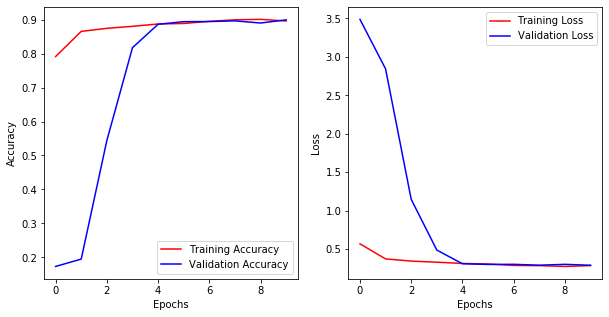

In [15]:
# Loss Curves
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history['acc'],'r',label='Training Accuracy')
ax1.plot(history.history['val_acc'],'b',label='Validation Accuracy')
ax1.legend()
ax1.set(xlabel='Epochs',ylabel='Accuracy')

ax2.plot(history.history['loss'],'r',label='Training Loss')
ax2.plot(history.history['val_loss'],'b',label='Validation Loss')
ax2.legend()
ax2.set(xlabel='Epochs',ylabel='Loss')

The base model layers are then unfrozen so we can refine the model further.

In [16]:
base_model.trainable=True

The model is then recompiled with a lower learning rate.

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
t=time.time()

history_fine=model.fit_generator(train_generator,epochs=20,steps_per_epoch=training_count//batch_size,
                            shuffle=True,verbose=1,validation_data=test_generator)

elapsed_fine=time.time()-t

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
220/220 [==============================] - 1664s 8s/step - loss: 0.2902 - acc: 0.8967 - val_loss: 0.3204 - val_acc: 0.8983
Epoch 2/20
220/220 [==============================] - 1647s 7s/step - loss: 0.1931 - acc: 0.9320 - val_loss: 0.2963 - val_acc: 0.8980
Epoch 3/20
220/220 [==============================] - 1645s 7s/step - loss: 0.1489 - acc: 0.9470 - val_loss: 0.2535 - val_acc: 0.9083
Epoch 4/20
220/220 [==============================] - 1656s 8s/step - loss: 0.1262 - acc: 0.9559 - val_loss: 0.2328 - val_acc: 0.9253
Epoch 5/20
220/220 [==============================] - 1650s 7s/step - loss: 0.1109 - acc: 0.9615 - val_loss: 0.2351 - val_acc: 0.9187
Epoch 6/20
220/220 [==============================] - 1654s 8s/step - loss: 0.0937 - acc: 0.9671 - val_loss: 0.3129 - val_acc: 0.9057
Epoch 7/20
220/220 [==============================] - 1654s 8s/step - loss: 0.0899 - acc: 0.9686 - val_loss: 0.2972 - val_acc: 0.9037
Epoch 8/20
220

In [19]:
elapsed_total=elapsed+elapsed_fine

The fine tuning is then plotted.

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

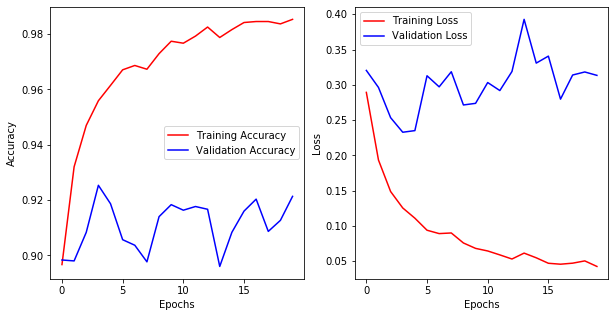

In [20]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(history_fine.history['acc'],'r',label='Training Accuracy')
ax1.plot(history_fine.history['val_acc'],'b',label='Validation Accuracy')
ax1.legend()
ax1.set(xlabel='Epochs',ylabel='Accuracy')

ax2.plot(history_fine.history['loss'],'r',label='Training Loss')
ax2.plot(history_fine.history['val_loss'],'b',label='Validation Loss')
ax2.legend()
ax2.set(xlabel='Epochs',ylabel='Loss')

Then the total loss and accuracy plots are made.

[Text(0, 0.5, 'Loss'), Text(0.5, 0, 'Epochs')]

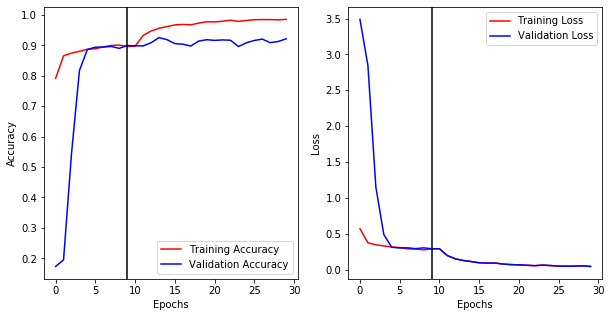

In [21]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(history.history['acc']+history_fine.history['acc'],'r',label='Training Accuracy')
ax1.plot(history.history['val_acc']+history_fine.history['val_acc'],'b',label='Validation Accuracy')
ax1.axvline(x=9,color='black')
ax1.legend()
ax1.set(xlabel='Epochs',ylabel='Accuracy')

ax2.plot(history.history['loss']+history_fine.history['loss'],'r',label='Training Loss')
ax2.plot(history.history['val_loss']+history_fine.history['loss'],'b',label='Validation Loss')
ax2.axvline(x=9,color='black')
ax2.legend()
ax2.set(xlabel='Epochs',ylabel='Loss')

The final trained model then predicts labels.

In [22]:
pred=model.predict_classes(test_generator)
test_labels=test_generator.classes

Again the confusion matrix and classification reports are made.

In [23]:
conf=confusion_matrix(test_labels,pred)

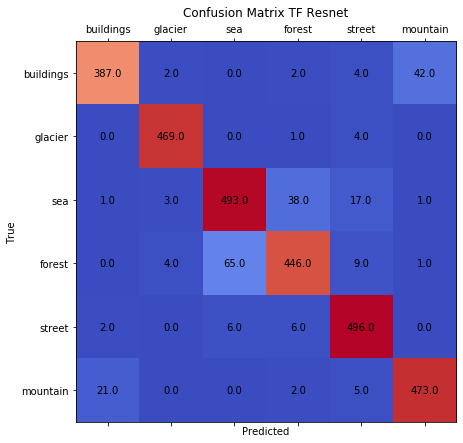

In [24]:
fig, ax = plt.subplots(figsize=(7,7))
ax.matshow(conf, cmap='coolwarm')
ax.set_xticklabels(['']+classes)
ax.set_yticklabels(['']+classes)
plt.title('Confusion Matrix TF Resnet')
plt.xlabel('Predicted')
plt.ylabel('True')

for (ii, jj), val in np.ndenumerate(conf):
    ax.text(jj, ii, '{:0.1f}'.format(val), ha='center', va='center')

plt.show()

In [25]:
CR=classification_report(test_labels,pred)

print(CR)

              precision    recall  f1-score   support

           0       0.94      0.89      0.91       437
           1       0.98      0.99      0.99       474
           2       0.87      0.89      0.88       553
           3       0.90      0.85      0.87       525
           4       0.93      0.97      0.95       510
           5       0.91      0.94      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



The total training times and final accuracy are reported and saved.

In [26]:
acc=accuracy_score(test_labels,pred)

print('Training Time: ', elapsed_total)
print('Final Accuracy: ', acc)
np.save('TF+Keras_resnet',(elapsed_total,acc))

Training Time:  39322.91896033287
Final Accuracy:  0.9213333333333333
